In [1]:
import json
import pandas as pd
today = "_debug/2019-06-23"

In [2]:
import json
def read_json(filename):
    with open(filename, "r") as f:
        return json.load(f)

- [x] time vs best score for 4 different algs
- [x] predictions for `random_state=0`
- [.] (have data) cluster activity for `random_state=0`

In [14]:
# list of arrays for each model.
# DIR = "./"
DIR = f"./out/{today}/"
DIR = f"{today}/out/"
DIR = "./"

# list of arrays with each score/time/etc. Each model entered more than once.

# ordered by adaptive-ness
ALGS = [
#     "passive",
#     "patience",
    "hyperband-w-patience",
    "hyperband",
]
RAND_STATES = range(1)

cv_results = {
    alg: [read_json(DIR + f"{today}-{alg}-{random_state}-cv_results.json")
    for random_state in RAND_STATES]
    for alg in ALGS
}
histories = {
    alg: [read_json(DIR + f"{today}-{alg}-{random_state}-history.json")
    for random_state in RAND_STATES]
    for alg in ALGS
}

params = {
    alg: [read_json(DIR + f"{today}-{alg}-{random_state}-params.json")
    for random_state in RAND_STATES]
    for alg in ALGS
}

best = {
    alg: [
        read_json(DIR + f"{today}-{alg}-{random_state}-best-params-and-score.json")
        for random_state in RAND_STATES
    ]
    for alg in ALGS
}

In [15]:
from pprint import pprint
pprint(best)

{'hyperband': [{'params': {'batch_size': 128,
                           'module__activation': 'ELU',
                           'module__init': 'kaiming_normal_',
                           'optimizer': 'Adam',
                           'optimizer__lr': 0.2105345242766705,
                           'optimizer__momentum': 0.1841841841841842,
                           'optimizer__nesterov': True,
                           'optimizer__weight_decay': 0,
                           'train_split': None},
                'score': -0.10495488345623016}],
 'hyperband-w-patience': [{'params': {'batch_size': 256,
                                      'module__activation': 'PReLU',
                                      'module__init': 'kaiming_uniform_',
                                      'optimizer': 'Adam',
                                      'optimizer__lr': 3.8201646550322357,
                                      'optimizer__momentum': 0.4014014014014014,
                            

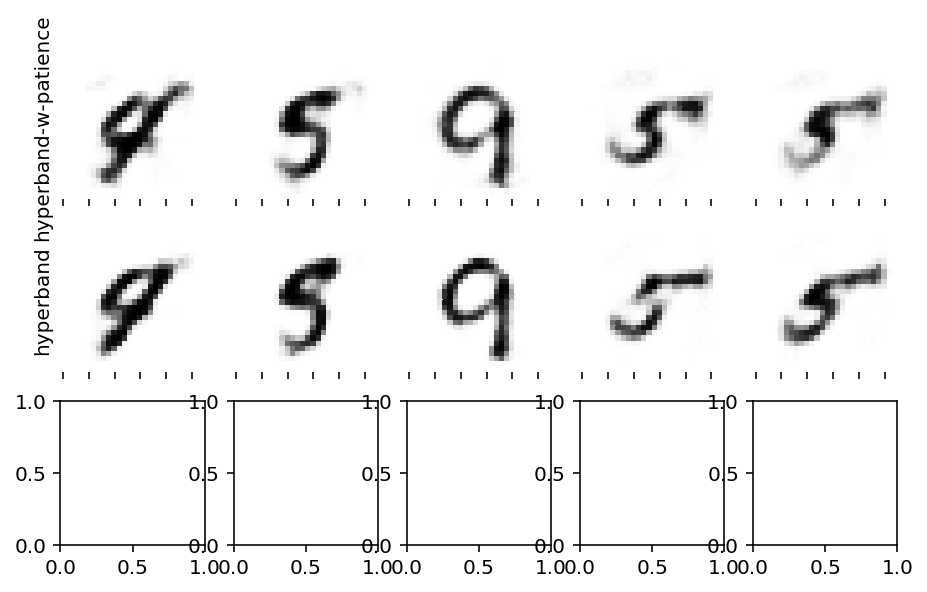

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

ests = {alg: np.load(DIR + f"{today}-{alg}-0-test.npz")["y_hat"]
        for alg in ALGS}

w = 1.5

show = np.random.choice(len(ests["hyperband"]), size=5)
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(5*w, 3*w))
for (name, imgs), row in zip(ests.items(), axs):
    for i, (img, ax) in enumerate(zip(imgs, row)):
        ax = sns.heatmap(imgs[show[i]].reshape(28, 28), ax=ax, cmap="gray_r", cbar=False)
        ax.yaxis.set_major_locator(plt.NullLocator())
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        if i == 0:
            _ = ax.set_ylabel(name)

## Performance
`HyperbandCV` will find close to the best possible parameters with the given computational budget.*

<sup>* "will" := with high probability,
"close" := within log factors,
"best possible" in expected value.</sup>


In [6]:
def shape_history(history, **kwargs):
    """
    TODO: get list of times, smooth over that
    
    out = []
    for row in history:
        time = next(times)
        if time < row["time"]:
            out += [out[-1]]
        out += [process(row)]  
    """
    
    scores = {}
    pf_calls = {}
    
    out = []
    cumulative_pf_calls = 0
    
    start = history[0]["elapsed_wall_time"]
    for row in history:
        scores[row["model_id"]] = row["score"]
        pf_calls[row["model_id"]] = row["partial_fit_calls"]
        cumulative_pf_calls = sum(pf_calls.values())
        
        out += [{"best_score": max(scores.values()),
                 "elapsed_wall_time": row["elapsed_wall_time"] - start,
                 "cumulative_partial_fit_calls": sum(pf_calls.values()),
                 **kwargs}]
    return out

In [7]:
medium_rare = [shape_history(hist, repeat=k, alg=alg)
               for alg, hists in histories.items()
               for k, hist in enumerate(hists)]
# medium = [smooth_histories(hist) for hist in medium_rare]

well_done = sum(medium_rare, [])

In [8]:
import pandas as pd
df = pd.DataFrame(well_done)
df.head(n=2)
df.elapsed_wall_time.describe()
print(df.alg.unique())
df.head()

['passive' 'patience' 'hyperband-w-patience' 'hyperband']


,alg,best_score,cumulative_partial_fit_calls,elapsed_wall_time,repeat
0,passive,0.757778,1,0.000000e+00,0
1,passive,0.757778,2,9.536743e-07,0
2,passive,0.757778,3,1.907349e-06,0
3,passive,0.757778,4,3.099442e-06,0
4,passive,0.757778,5,4.053116e-06,0


In [9]:
# Discretize
df["cumulative_partial_fit_calls"] = np.round(df.cumulative_partial_fit_calls, decimals=-1)

time_resolution_secs = 2
df["elapsed_wall_time"] = (df.elapsed_wall_time // time_resolution_secs) * time_resolution_secs

['passive' 'stop-on-plateau' 'hyperband+sop' 'hyperband']


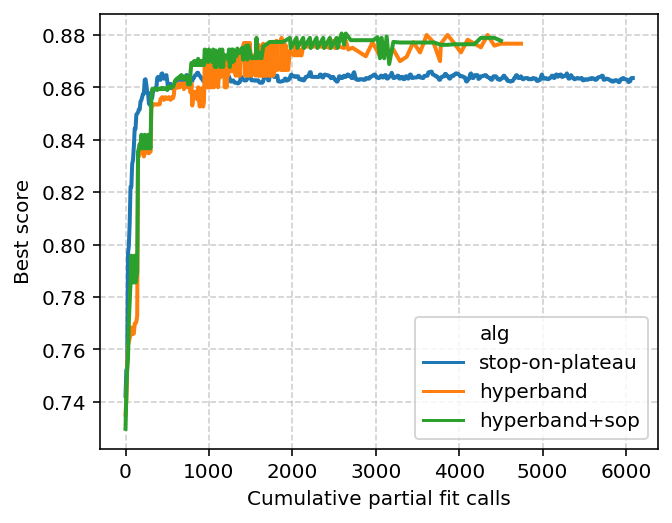

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
# plt.style.use()

show = df.copy()
idx = show.alg == "patience"
show.loc[idx, "alg"] = "stop-on-plateau"
idx = show.alg == "hyperband-w-patience"
show.loc[idx, "alg"] = "hyperband+sop"
print(show.alg.unique())

# algs = ["passive", "stop-on-plateau", "hyperband", "hyperband+sop"]
algs = ["stop-on-plateau", "hyperband", "hyperband+sop"]

# show["Passes through data"] = df["cumulative_partial_fit_calls"] / 3
fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.lineplot(
    data=show,
    x="cumulative_partial_fit_calls",
    y="best_score",
    hue="alg",
    hue_order=algs,
    ci=None,
    linewidth=2,
    ax=ax,
)
# ax.set_ylim(-0.12, -0.09)
ax.grid(linestyle="--", alpha=0.6)
ax.set_ylabel("Best score")
ax.set_xlabel("Cumulative partial fit calls")
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
# plt.savefig(f"{today}-cum-calls.svg", bbox_inches="tight")

In [11]:
# s = df[df.alg == "hyperband-w-patience"]

Text(0.5, 0, 'Elapsed time (min)')

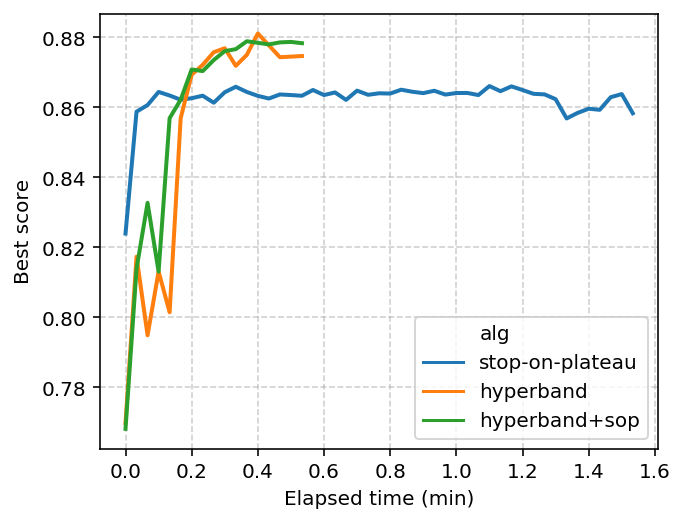

In [12]:
import seaborn as sns

show["elapsed_wall_time (min)"] = show["elapsed_wall_time"] / 60

fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.lineplot(
    data=show,
    x="elapsed_wall_time (min)",
    y="best_score",
    hue="alg",
    hue_order=algs,
    ci=None,
    linewidth=2,
    ax=ax,
)
# ax.set_ylim(-0.12, -0.09)
# ax.set_xlim(0, 2)
ax.grid(linestyle="--", alpha=0.6)
ax.set_ylabel("Best score")
ax.set_xlabel("Elapsed time (min)")
# plt.savefig(f"{today}-wall-time.svg", bbox_inches="tight")

## Parameter visualization

In [ ]:
# results = {k: [result[k] for result in cv_results["patience"]]
#               for k in cv_results["patience"][0]}
# results = {k: sum(v, []) for k, v in results.items()}

In [ ]:
import numpy as np
hist = pd.DataFrame(cv_results["patience"])
hist.head()

#hist['param_optimizer_'] = hist['param_optimizer'].apply(lambda opt: str(opt).replace('<class', '').strip('>'))
hist['test_loss'] = -1 * hist['test_score']
hist = hist.sort_values(by='test_loss')
hist['rank'] = np.arange(len(hist)) + 1
hist.head()

In [45]:
def make_rank_plot(hues, w=5):
    w = 5
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(2*w, 1*w))
    axs = axs.flat[:]
    print("{} estimators".format(len(hist)))
    for ax, hue in zip(axs, hues):
        cmap = None
        if 'batch_size' in hue:
            cmap = 'viridis'
        sns.barplot(
            x='rank', 
            y='test_loss',
            hue=hue,
            data=hist,
            ax=ax,
            palette=cmap,
            dodge=False,
        )
        ax.set_xlim(-1.5, len(hist) - 20)
        ax.grid(linestyle='--', axis='y', alpha=0.6)
        ax.legend(loc='lower right')
        ax.set_title(hue.replace('param_', ''))
        #ax.tick_params(labelbottom=False)
    #     yticks = [0, 0.03, 0.06, 0.09]
    #     yticks = set(yticks).union({0.09, 0.1, 0.11, 0.12})
    #     ax.set_yticks(list(yticks))
        ranks = np.array([2, 4, 6, 8, 10, 15, 20, 25, 30, 35, 40])
        ax.set_xticks(ranks - 1)
        ax.set_xticklabels([str(r) for r in ranks])
        ax.set_ylim(0.07, 0.13)
    return fig

64 estimators


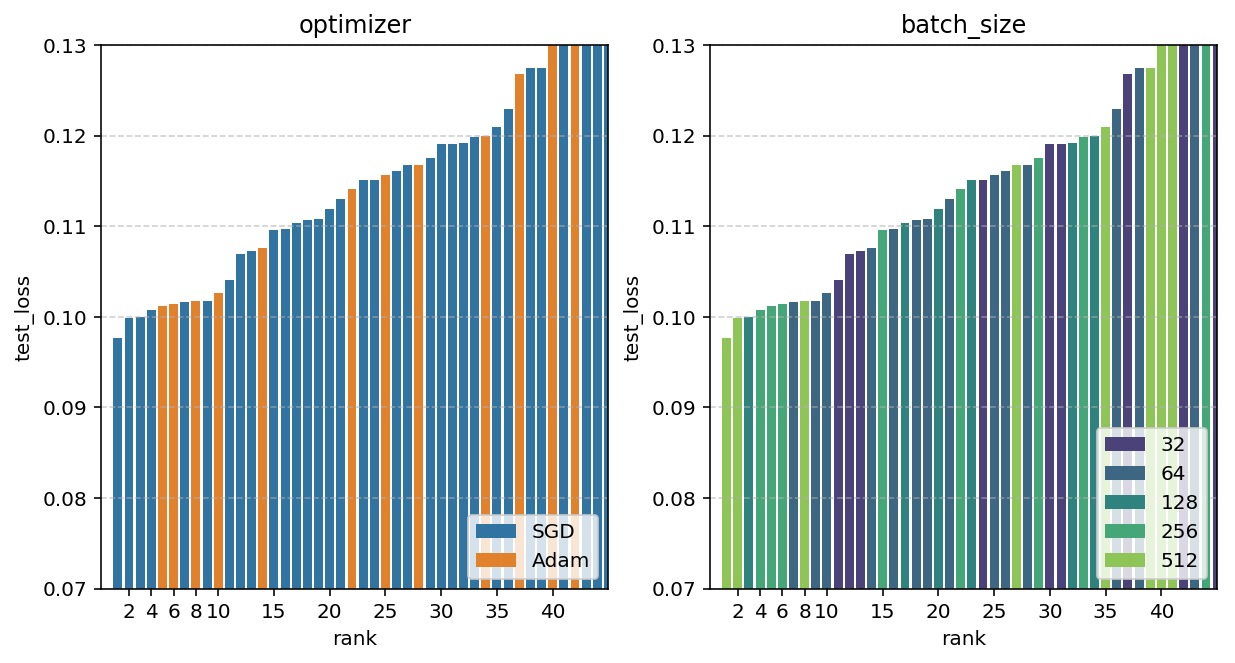

In [46]:
hues = ['param_optimizer', 'param_batch_size', 'param_module__init', 'param_module__activation', ]
fig = make_rank_plot(hues[:2])
plt.savefig("figs/ranks-opt.svg", bbox_inches="tight")
plt.show()

64 estimators


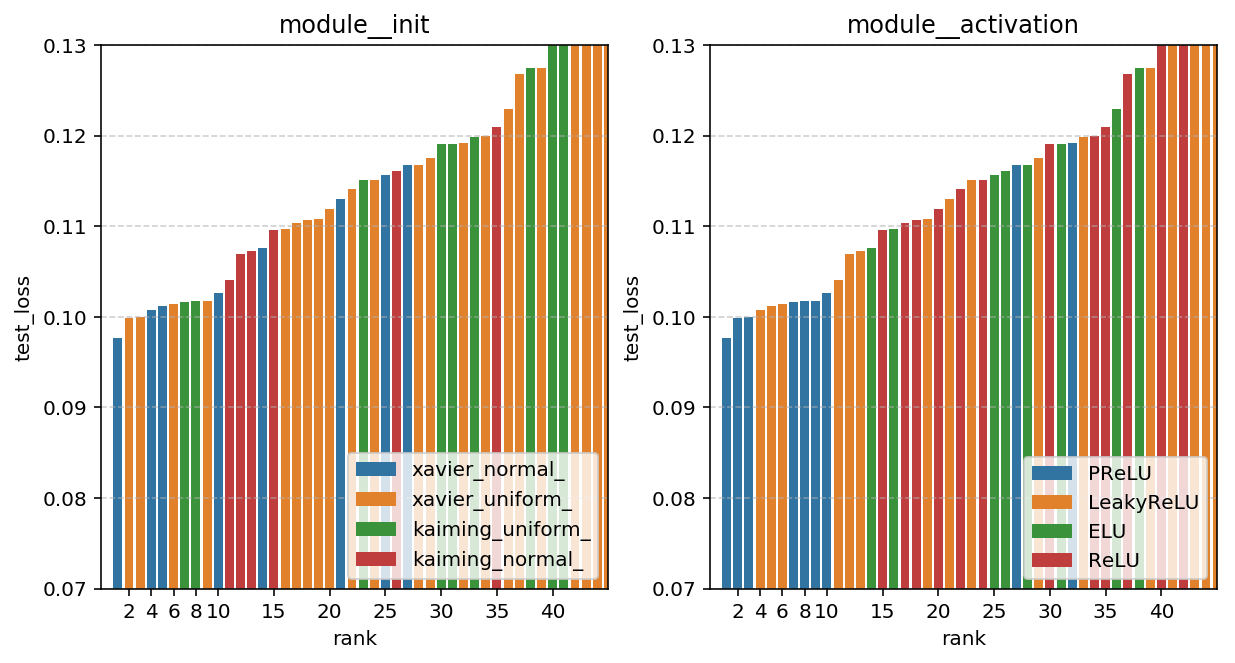

In [47]:
fig = make_rank_plot(hues[2:])
plt.savefig("figs/ranks-module.svg", bbox_inches="tight")
plt.show()

In [48]:
sgd_alg = [a for a in hist.param_optimizer.unique() if 'sgd' in a.lower()][0]
sgd = hist[hist.param_optimizer == sgd_alg]
sgd.head()

,mean_partial_fit_time,mean_score_time,std_partial_fit_time,std_score_time,test_score,estimator_id,params,partial_fit_calls,param_train_split,param_optimizer__weight_decay,param_optimizer__nesterov,param_optimizer__momentum,param_optimizer__lr,param_optimizer,param_module__init,param_module__activation,param_batch_size,rank_test_score,test_loss,rank
52,1.811502,0.998081,0.171949,0.208034,-0.097640,52,"{'train_split': None, 'optimizer__weight_decay...",90,None,0.000000,True,0.788789,2.184436,SGD,xavier_normal_,PReLU,512,1,0.097640,1
8,1.773526,0.964918,0.135924,0.164505,-0.099922,8,"{'train_split': None, 'optimizer__weight_decay...",148,None,0.000058,True,0.677678,0.583803,SGD,xavier_uniform_,PReLU,512,2,0.099922,2
5,2.011763,0.988775,0.202603,0.167742,-0.100015,5,"{'train_split': None, 'optimizer__weight_decay...",166,None,0.000112,True,0.518519,0.355673,SGD,xavier_uniform_,PReLU,128,3,0.100015,3
27,1.908410,0.974589,0.188901,0.208935,-0.100752,27,"{'train_split': None, 'optimizer__weight_decay...",136,None,0.000030,True,0.903904,1.300511,SGD,xavier_normal_,LeakyReLU,256,4,0.100752,4
22,2.247364,0.979484,0.193871,0.155740,-0.101628,22,"{'train_split': None, 'optimizer__weight_decay...",83,None,0.000045,True,0.312312,3.443793,SGD,kaiming_uniform_,PReLU,64,7,0.101628,7


In [61]:
def make_param_plot(variables, w=5):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(2*w, 1*w))
    axs = axs.flat[:]
    print(sgd.param_optimizer.unique())
    for k, (ax, var) in enumerate(zip(axs, variables)):
        show = sgd.copy()
        show = show.sort_values(by=var)
        if 'weight_decay' in var:
            show[var] += 1e-7
        show = show[show.test_loss < 0.16]
        sns.scatterplot(
            x=var,
            y='test_loss',
            data=show,
            hue='test_loss',
            palette='magma',
            legend=False,
            ax=ax,
        )
        if 'lr' in var:
            ax.set_xscale('log', basex=10)
        if 'batch_size' in var:
            ax.set_xscale('log', basex=2)
        if 'weight_decay' in var:
            ax.set_xlim(5e-9, 1e-3)
            ax.set_xscale('log', basex=10)

        ax.grid(linestyle='--', alpha=0.6)
        ax.set_ylim(0.09, 0.13)
        ax.set_xlabel(var.replace("param_", ""))
        if k == 1:
            ax.set_ylabel("")

['SGD']


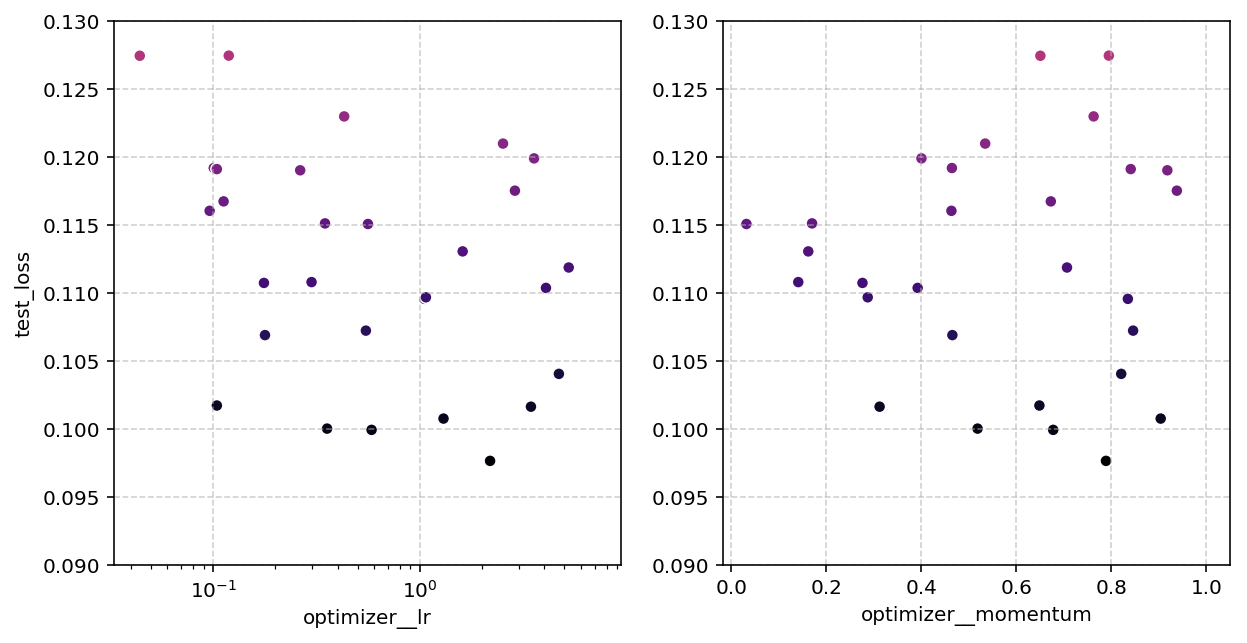

In [64]:
variables = ['param_optimizer__lr', 'param_optimizer__momentum', 'param_optimizer__weight_decay', 'param_batch_size']
make_param_plot(variables[:2])
plt.savefig("figs/sgd-opt.png", bbox_inches="tight")
plt.show()

['SGD']


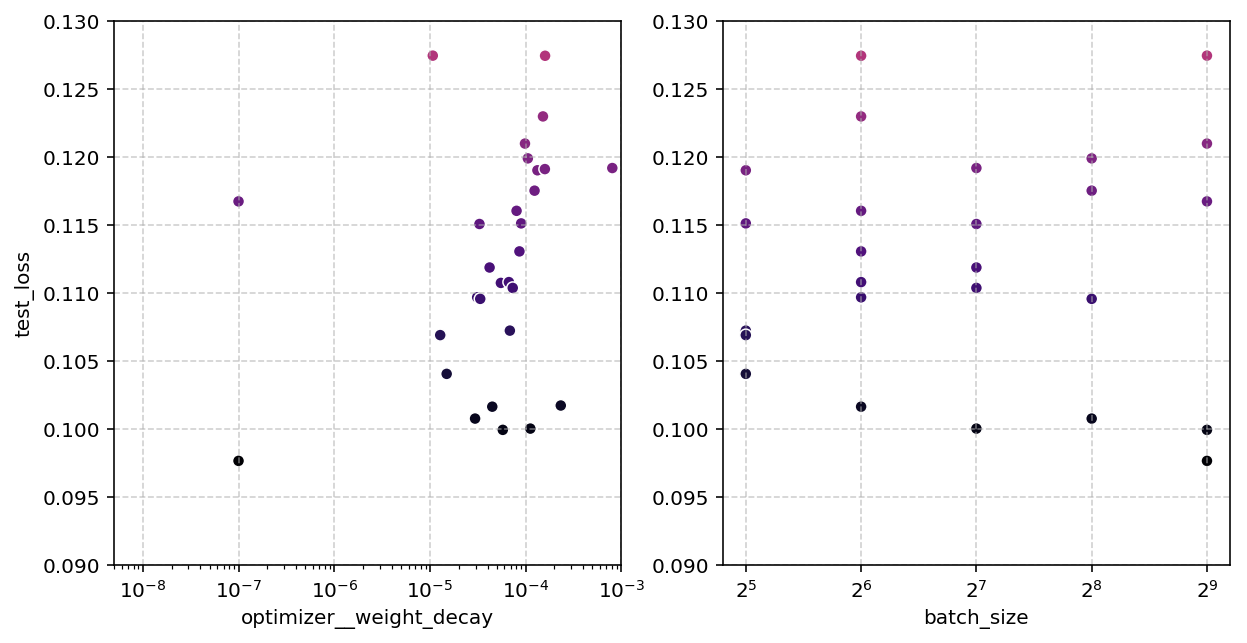

In [65]:
make_param_plot(variables[2:])
plt.savefig("figs/sgd-misc.png", bbox_inches="tight")
plt.show()